# Deep Learning and Inverse Problems - Summer 2024
## Problem Set 5 -- Solution

**Issued**: Tuesday, May 14, 2024, 1:00 pm

**Due**: Tuesday, May 28, 2024, 1:00 pm

# Recovering Images from CT Sinograms with a Variational Network

In computed tomography (CT), the tomography reconstruction problem is to obtain an image from a set of projections of that image. A projection is formed by drawing a set of parallel rays through the 2D object of interest, assigning the integral of the object’s contrast along each ray to a single pixel in the projection. A single projection of a 2D object is one dimensional. To enable computed tomography reconstruction of the object, several projections must be acquired, each of them corresponding to a different angle between the rays with respect to the object. A collection of projections at several angles is called a sinogram, which is a linear transform of the original image.
(only slightly adapted from https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html)


The goal of this homework is to implement a variational network that recovers CT images from few measurements. Training a variational network is time intensive, therefore we work with a few images only, and use a small network with only 2 layers per iteration/cascade. This setup save us computational time relative to working with real-world large datasets arising in practical applications.

Most of the implementation is set up already. After a brief introduction to CT, your task is to implement the variational network and train the model.

In [1]:
import torch

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.fft

from radon import get_operators

In [18]:
# uncomment these lines if you work in a colab notebook
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = "/content/drive/MyDrive/data/"

# for local development
data_path = "./data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Introduction

Let us first consider the linear forward map $A$, which in this case is the Radon transform. In this concrete example, we collect projections of a single 256x256 image at 32 different angles. The resulting sinogram (measurement $y$) is 256x32 dimensional.

In [15]:
device='cuda:0' #'cuda' for GPU, 'cpu' otherwise
radon_op, fbp_op = get_operators(n_angles=32, image_size=256, circle=True, device=device)

#forward model representing a radon transform
def A(x):
    y = radon_op(x)
    return y

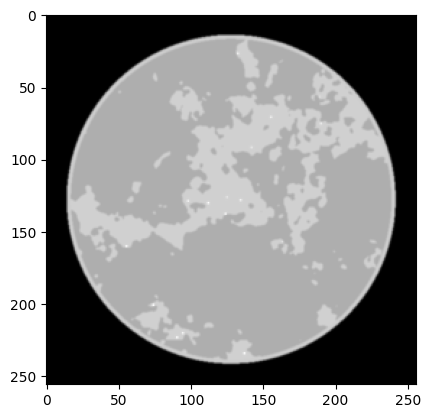

In [19]:
plt.gray()
img = torch.load(data_path+'0')
plt.imshow(img[0])

torch.Size([1, 1, 256, 32])


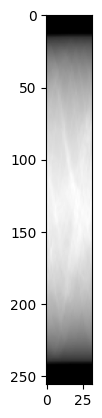

In [21]:
sinogram = A(img.unsqueeze(1).to(device))  # unsqueeze because A expects a channel dimension at location 1
print(sinogram.shape)
plt.imshow(sinogram.squeeze().cpu())

To implement a variational network for the CT problem, we need an implementation of the transpose forward map $A^T$ that maps sinograms back to images. Here, we approximate this transform with filtered back-projection (FBP). For this homework problem, you do not have to understand the defails of FBP. All you have to know is that it is an algorithm that takes a sinogram input and returns a coarse reconstruction of the original image as output.

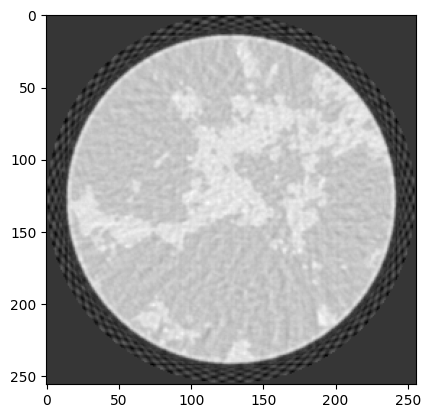

In [23]:
#We use filtered back projection as an estimate of A.T
def AT(y):
    x=fbp_op(y)
    x = x.to(torch.float32)
    return x

reconstruction = AT(sinogram)
plt.imshow(reconstruction.squeeze().cpu())

As you can see, the reconstruction exhibits some severe artefacts compared to the ground-truth image. This is because we took a 256x32 dimensional measurement of a 256x256 dimensional object, i.e. we only have a fraction of $\frac{256 \cdot 32}{256^2} = \frac{1}{8}$ of the $256^2$ measurements that would guarantee the possibility of perfect reconstruction. 

## Homework Problem Starts Here

### Dataset and Dataloaders

In [24]:
# torch dataset that returns sinograms and ground-truth images
class CTDataSet(torch.utils.data.Dataset):
    
    def __init__(self, path):
        self.path = path

    def __len__(self):
        return len(os.listdir(self.path))
    
    def __getitem__(self, idx):
        img = torch.load(self.path+str(idx)).to(device)
        sino = A(img.unsqueeze(1))
        return img.squeeze(), sino.squeeze()

In [25]:
data_set = CTDataSet(data_path)

#Split dataset into 99 imgs for training and 1 img for validation
train_set, val_set = torch.utils.data.random_split(data_set,[99,1],generator=torch.Generator().manual_seed(0))

#Dataloader
train_dl = DataLoader(train_set, batch_size=1)
val_dl = DataLoader(val_set, batch_size=1)

### Variational network

The task is to implement a variational network in the cell below. The network consists of num_cascades = 5, i.e., has 5 iterations. The network should output the reconstruction after every cascade (see last cell).

The network is initialized as 
$$
x^t = A^T y,
$$
and implements the iterations
$$
x^{t+1} = x^t - \eta (A^T(Ax^t -y) + R_t(x^t)),
$$
where $R_t$ is a regularizer parameterized as
$$
R_t(x) = \sum_{i=1}^k C_{t,1,i}^T relu(C_{t,2,i} x).
$$
Here, $C_{t,j,i}$ is a convolution with a kernel of size $3\times 3$. Note that the regularizer is a simple convolutional network that can be implemented with the functions nn.Conv2d() and nn.ReLU(). The parameter $\eta$ is a trainable parameter, initialize it to $\eta=0.01$.

In [29]:
# fill in code here
# you are free to create as many classes as you need



#Whole Variational Network    
class VarNet(nn.Module):
    def __init__(self, num_cascades=5):
        super(VarNet, self).__init__()
        
        # fill in code here
        
    def forward(self, y):
        
        # fill in code here
         
        return

### Solution

In [47]:

#Regularizer
class Regularizer(nn.Module):
    def __init__(self, k=32, s=3):
        super(Regularizer, self).__init__()
        
        self.k=k  #number of channels
        self.s=s  #filter size
        self.conv1 = nn.Conv2d( 1, self.k ,kernel_size= self.s, stride=1, padding=1)
        self.non_linearity = nn.ReLU()
        self.conv2= nn.Conv2d( self.k, 1 ,kernel_size= self.s, stride=1, padding=1)
        
    def forward(self, x): 
        out= self.conv2(self.non_linearity(self.conv1(x)))
        return out
    
#Cascade
class Cascade(nn.Module):
    def __init__(self,model: nn.Module):
        super(Cascade, self).__init__()
        
        self.model = model
        self.step_size=nn.Parameter(torch.tensor(0.010))
        
    def forward(self, x, y):
        Rx=self.model(x).squeeze(0)
        pred = x - self.step_size*(AT(A(x) - y)+ Rx)
    
        return pred

#Whole Variational Network    
class VarNet(nn.Module):
    def __init__(self, num_cascades=8):
        super(VarNet, self).__init__()
        
        self.num_cascades=num_cascades
        self.cascades = nn.ModuleList([Cascade(Regularizer()) for _ in range(self.num_cascades)])
        
    def forward(self, y):
        
        x_int=[] # capture intermediate x 
        x=AT(y)  # initialise x with A^Ty
        x_int.append(x)
        
        for cascade in self.cascades:
            x = cascade(x,y)
            x_int.append(x)
        
        return x_int  

### Below are funtions to train and test the network

You can modify the functions or the hyperparameters for training as you wish

In [48]:
##Loss
def mse(gt: torch.Tensor, pred:torch.Tensor)-> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt,pred)

#train function
def train_step(model, optimizer, dataloader_sample):
    model.train()
    
    # reset optimizer's gradient
    optimizer.zero_grad()

    # define variables
    x, y = dataloader_sample
      
    # get the prediction
    pred = model(y.unsqueeze(1))[-1].squeeze(1)
    pred_loss = mse(pred, x)
    
    #one step of training
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item()

#test function
def validation_step(model, dataloader_sample): 
    model.eval()
    
    with torch.no_grad(): 
        
        x, y = dataloader_sample
        
        # get the prediction
        pred = model(y.unsqueeze(1))[-1].squeeze(1)
        pred_loss = mse(pred, x)

    return pred_loss.item()

### Training

As optimizer, we choose the Adam optimizer (a standard adaptive gradient method). We then train the model for 10 epochs; training for more epochs gives better results, but after 10 epochs we already get a model that works reasonably well for image recovery.

In [49]:
model = VarNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)

max_epoch = 10
mse_train=[]
mse_val= []

for epoch in tqdm(range(max_epoch)):
    # Initialize Loss and Accuracy
    train_loss = val_loss= 0.0
    
    ### Training Phase
    
    ## Iterate over the train_dataloader
    with tqdm(total=len(train_dl)) as pbar:
        for sample in train_dl:            
            curr_loss = train_step(model, optimizer, sample)
            train_loss += curr_loss / len(train_dl) 
            pbar.update(1)
    
    mse_train.append(train_loss)


    ### Validation Phase 
    
    ## Validation_dataloader
    with tqdm(total=len(val_dl)) as pbar:
        for sample in val_dl: 
            curr_loss = validation_step(model, sample)
            val_loss += curr_loss / len(val_dl)
            pbar.update(1)
    
    mse_val.append(val_loss) 
    
    print(epoch, train_loss, val_loss)    


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 0.0007353354618188482 0.0004914710880257189


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1 0.0003322084039517894 0.0002562745939940214


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2 0.00022401928222876957 0.0002158844581572339


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3 0.0001973882929752393 0.00019671811605803668


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4 0.00018315250105447968 0.0001854859001468867


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 0.00017422927927750282 0.00017678816220723093


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6 0.00016718569098186277 0.00016990513540804386


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

7 0.0001599081336124329 0.00016351896920241416


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

8 0.00015429503224423212 0.00015814206562936306


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9 0.00014934302401738335 0.0001537276984890923


Text(0, 0.5, 'MSE')

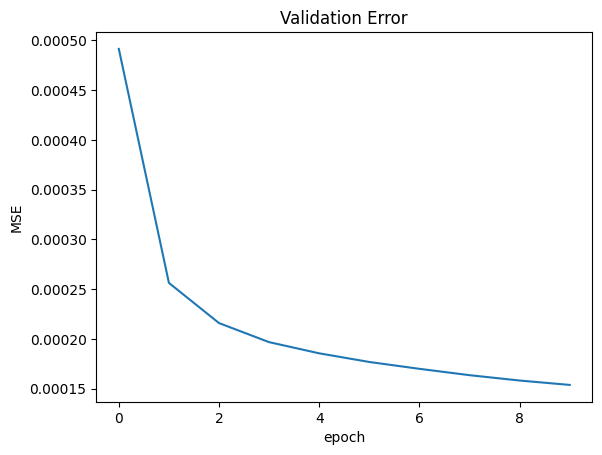

In [50]:
plt.plot(mse_val)
plt.title('Validation Error')
plt.xlabel('epoch')
plt.ylabel('MSE')

### Visualization how VarNet reconstructs an image

Text(0.5, 1.0, 'Ground Truth')

<Figure size 640x480 with 0 Axes>

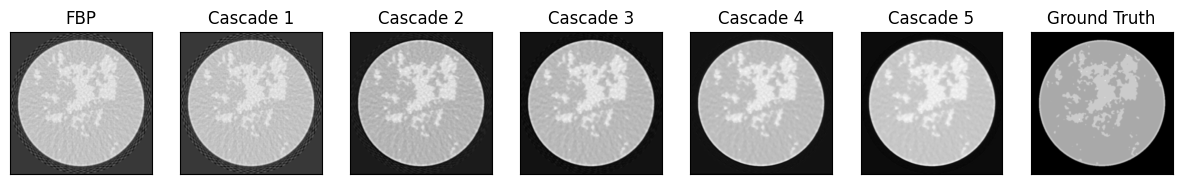

In [51]:
sample=next(iter(val_dl))  #img from val set

#reconstruction
with torch.no_grad(): 
    x, y = sample
    pred = model(y.unsqueeze(1))
    fbp = AT(y.unsqueeze(1))

plt.gray()
fig, ax = plt.subplots(1, 7,figsize=(15, 15))

ax[0].imshow(fbp.squeeze().cpu())
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('FBP') 

for i in range(5):
    ax[i+1].imshow(pred[i].squeeze().cpu())
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_title('Cascade '+ str(i+1))
    
ax[6].imshow(x.squeeze().cpu())   
ax[6].set_xticks([])
ax[6].set_yticks([])
ax[6].set_title('Ground Truth')  